# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [2]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import librosa
import librosa.display
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
dataset_path = "/content/drive/MyDrive/data/unlabelled_sounds/unlabelled_sounds"

def explore_sound_dataset(data_path):
    """
    Explore the sound dataset to understand what we're working with
    """
    # Get all .wav files
    wav_files = [f for f in os.listdir(data_path) if f.endswith('.wav')]

    print(f"Dataset Overview:")
    print(f"Total .wav files: {len(wav_files)}")

    # Examine a few sample files
    sample_files = wav_files[:3]  # Looks at the first 3 files

    for i, filename in enumerate(sample_files):
        file_path = os.path.join(data_path, filename)

        # Load the audio file
        y, sr = librosa.load(file_path)

        print(f"\n File {i+1}: {filename}")
        print(f"   Duration: {len(y)/sr:.2f} seconds")
        print(f"   Sample rate: {sr} Hz")
        print(f"   Total samples: {len(y)}")
        print(f"   Audio range: {y.min():.3f} to {y.max():.3f}")

# Run this first
explore_sound_dataset(dataset_path)

Dataset Overview:
Total .wav files: 3010

 File 1: 2011.wav
   Duration: 0.44 seconds
   Sample rate: 22050 Hz
   Total samples: 9727
   Audio range: -0.578 to 0.431

 File 2: 2004.wav
   Duration: 0.40 seconds
   Sample rate: 22050 Hz
   Total samples: 8743
   Audio range: -0.059 to 0.044

 File 3: 1636.wav
   Duration: 1.00 seconds
   Sample rate: 22050 Hz
   Total samples: 22048
   Audio range: -0.646 to 0.488


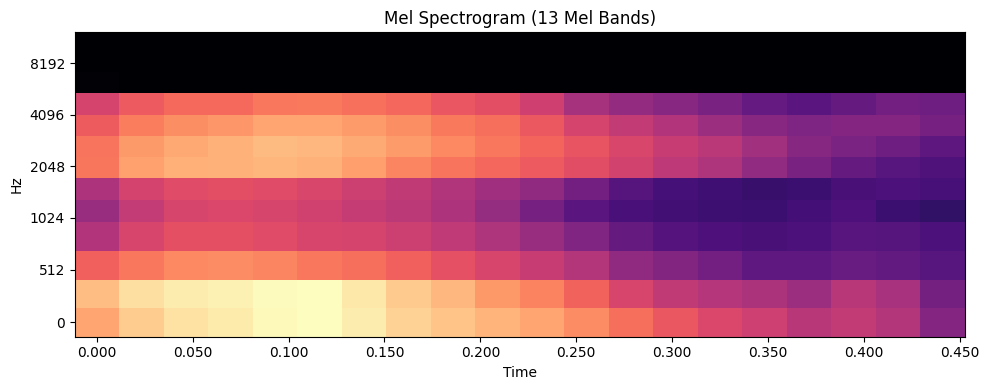

Mel spectrogram shape: (13, 20)


In [29]:
def melspec(data_path, filename):
    """
     The audio mel spectrogram
    """
    file_path = os.path.join(data_path, filename)
    y, sr = librosa.load(file_path)

    # Create subplot


    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=13)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(mel_spec_db, y_axis='mel', x_axis='time', sr=sr, ax=axes)
    axes.set_title('Mel Spectrogram (13 Mel Bands)')

    plt.tight_layout()
    plt.show()

    # Show the shape
    print(f"Mel spectrogram shape: {mel_spec_db.shape}")

    return mel_spec_db

# Try this with one of your files
mel_data = melspec(dataset_path, "2031.wav")

In [31]:
def extract_mel_features(data_path, n_mels=13, max_files=100):
    """
    Extract fixed-size features from mel spectrograms
    """
    wav_files = [f for f in os.listdir(data_path) if f.endswith('.wav')][:max_files]

    features_list = []
    filenames = []

    print(f"Processing {len(wav_files)} files...")

    for i, filename in enumerate(wav_files):
        try:
            # Load audio
            file_path = os.path.join(data_path, filename)
            y, sr = librosa.load(file_path)

            # Extract mel spectrogram
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

            # Create FIXED-SIZE features by taking statistics across time
            features = np.concatenate([
                np.mean(mel_spec_db, axis=1),  # Mean of each mel band
                np.std(mel_spec_db, axis=1),   # Standard deviation
                np.max(mel_spec_db, axis=1),   # Maximum value
                np.min(mel_spec_db, axis=1)    # Minimum value
            ])

            features_list.append(features)
            filenames.append(filename)

            if (i + 1) % 25 == 0:
                print(f"Processed {i + 1} files...")

        except Exception as e:
            print(f"Error processing {filename}: {e}")

    features_array = np.array(features_list)
    print(f"\nFinal feature matrix shape: {features_array.shape}")

    return features_array, filenames

# Extract features from first 100 files
features, file_list = extract_mel_features(dataset_path, n_mels=13, max_files=100)

Processing 100 files...
Processed 25 files...
Processed 50 files...
Processed 75 files...
Processed 100 files...

Final feature matrix shape: (100, 52)


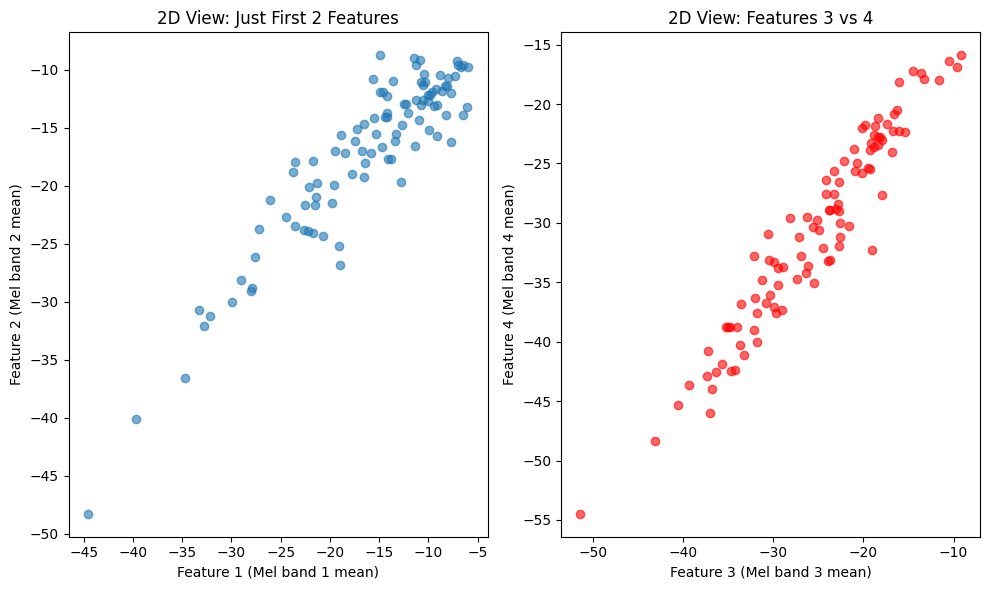

In [33]:
def try_visualizing_high_dimensions(features):
    """
    Visualizing high-dimensional data and see what happens
    """
    try:
        plt.figure(figsize=(10, 6))

        # Plotting a "pairs plot" of first 4 features
        plt.subplot(1, 2, 1)
        plt.scatter(features[:, 0], features[:, 1], alpha=0.6)
        plt.xlabel('Feature 1 (Mel band 1 mean)')
        plt.ylabel('Feature 2 (Mel band 2 mean)')
        plt.title('2D View: Just First 2 Features')


        plt.subplot(1, 2, 2)
        plt.scatter(features[:, 2], features[:, 3], alpha=0.6, color='red')
        plt.xlabel('Feature 3 (Mel band 3 mean)')
        plt.ylabel('Feature 4 (Mel band 4 mean)')
        plt.title('2D View: Features 3 vs 4')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

try_visualizing_high_dimensions(features)

### Why is dimensionality reduction important?
Dimentionality reduction is very importanat because it makes data simpler by reducing the number of features, which if done properly enhances the models performance and aid with data visualization. it also helps mitigate the "curse of dimensionality" and makes complex datasets easier to manage.
Attempting to visualize raw Mel Spectrogram features was ineffective due to their high dimensionality (hundreds of features). This justifies the need for dimensionality reduction techniques like PCA and t-SNE.

### Challenges or errors faced when trying to visualize high-dimensional data:

*   Scatter plots of 2D projections failed to reveal any natural clusters
*  We're missing information from the other features
*  Data appeared highly overlapping and noisy.



In [35]:
def apply_dimensionality_reduction(features, n_components=3):
    """
    Applying both PCA and t-SNE and compare them
    """
    # Step 1: Standardize the features (very important!)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    print(f"Original features shape: {features.shape}")
    print(f"Applying dimensionality reduction to {n_components} components")

    # Step 2: Apply PCA
    pca = PCA(n_components=n_components, random_state=42)
    features_pca = pca.fit_transform(features_scaled)

    # Step 3: Apply t-SNE
    tsne = TSNE(n_components=n_components, random_state=42, perplexity=30)
    features_tsne = tsne.fit_transform(features_scaled)

    print(f"PCA reduced shape: {features_pca.shape}")
    print(f"t-SNE reduced shape: {features_tsne.shape}")

    # Step 4: Show how much variance PCA captures
    print(f"\nPCA Explained Variance Ratio:")
    for i, var in enumerate(pca.explained_variance_ratio_):
        print(f"  Component {i+1}: {var:.3f} ({var*100:.1f}%)")
    print(f"Total variance captured: {pca.explained_variance_ratio_.sum():.3f} ({pca.explained_variance_ratio_.sum()*100:.1f}%)")

    return features_pca, features_tsne, features_scaled

features_pca, features_tsne, features_scaled = apply_dimensionality_reduction(features, n_components=3)

Original features shape: (100, 52)
Applying dimensionality reduction to 3 components
PCA reduced shape: (100, 3)
t-SNE reduced shape: (100, 3)

PCA Explained Variance Ratio:
  Component 1: 0.414 (41.4%)
  Component 2: 0.153 (15.3%)
  Component 3: 0.137 (13.7%)
Total variance captured: 0.705 (70.5%)


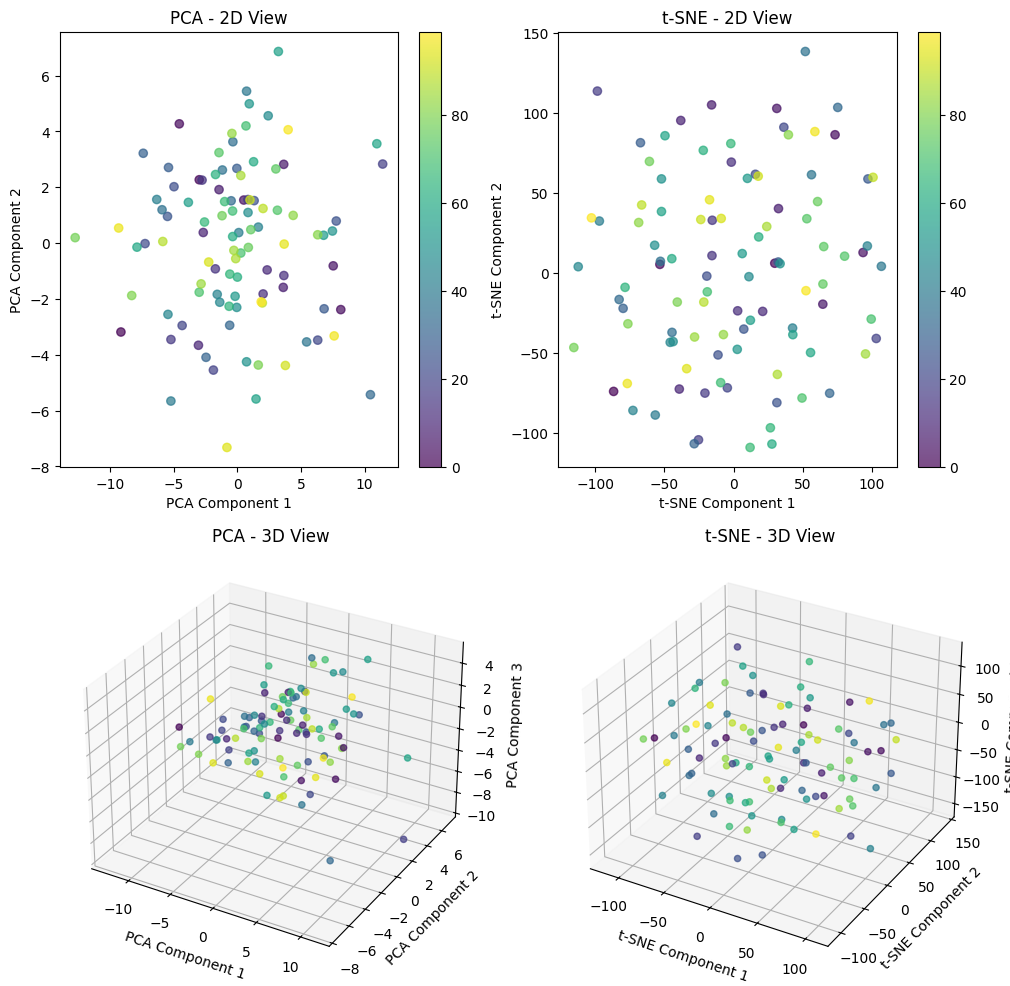

In [37]:
def compare_pca_vs_tsne(features_pca, features_tsne, method_names=['PCA', 't-SNE']):
    """
    Createing visualizations to compare PCA vs t-SNE
    """
    fig = plt.figure(figsize=(15, 10))

    # 2D visualizations
    for i, (features_2d, method) in enumerate(zip([features_pca[:, :2], features_tsne[:, :2]], method_names)):
        plt.subplot(2, 3, i+1)
        scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                            c=range(len(features_2d)), cmap='viridis', alpha=0.7)
        plt.xlabel(f'{method} Component 1')
        plt.ylabel(f'{method} Component 2')
        plt.title(f'{method} - 2D View')
        plt.colorbar(scatter)

    # 3D visualizations
    from mpl_toolkits.mplot3d import Axes3D

    for i, (features_3d, method) in enumerate(zip([features_pca, features_tsne], method_names)):
        ax = fig.add_subplot(2, 3, i+4, projection='3d')
        scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2],
                           c=range(len(features_3d)), cmap='viridis', alpha=0.7)
        ax.set_xlabel(f'{method} Component 1')
        ax.set_ylabel(f'{method} Component 2')
        ax.set_zlabel(f'{method} Component 3')
        ax.set_title(f'{method} - 3D View')

    plt.tight_layout()
    plt.show()

compare_pca_vs_tsne(features_pca, features_tsne)

### Which method (PCA or t-SNE) provides better separability of clusters and why?
Visually, t-SNE gives the impression of better-separated clusters in both 2D and 3D, thanks to its ability to capture complex, non-linear structures. In contrast, PCA shows more general spread but less clear groupings.

However, when applying clustering algorithms like K-Means, PCA outperformed t-SNE based on evaluation metrics. The silhouette and Davies-Bouldin scores were higher for PCA, indicating more compact and well-separated clusters.

In summary: t-SNE looked better visually, but PCA provided better actual clustering performance, showing that good-looking plots don't always mean better results.



Finding optimal K for PCA...
K=2: Inertia=2304.24, Silhouette=0.266
K=3: Inertia=1691.13, Silhouette=0.299
K=4: Inertia=1354.91, Silhouette=0.286
K=5: Inertia=1097.86, Silhouette=0.320
K=6: Inertia=936.90, Silhouette=0.335
K=7: Inertia=840.00, Silhouette=0.321
K=8: Inertia=763.53, Silhouette=0.302


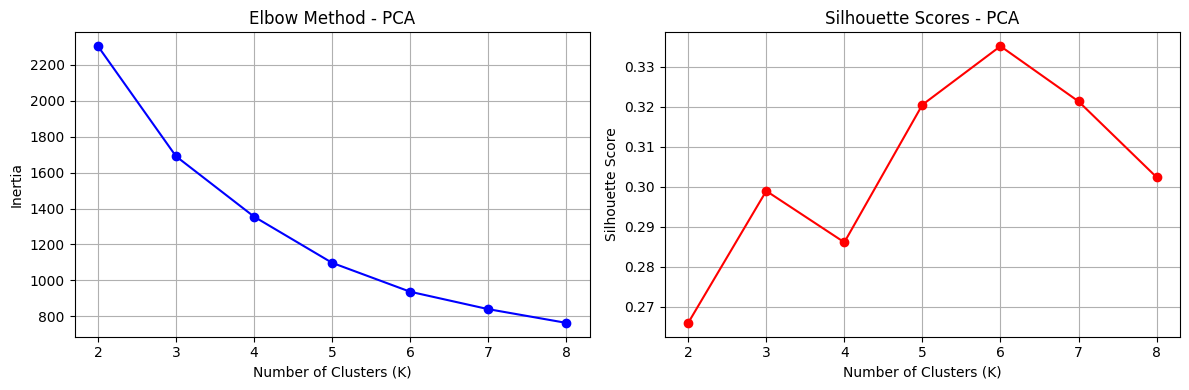

Best K for PCA: 6 (Silhouette: 0.335)
Finding optimal K for t-SNE...
K=2: Inertia=753278.50, Silhouette=0.256
K=3: Inertia=578285.50, Silhouette=0.256
K=4: Inertia=477747.84, Silhouette=0.249
K=5: Inertia=406119.88, Silhouette=0.243
K=6: Inertia=361207.09, Silhouette=0.230
K=7: Inertia=311515.56, Silhouette=0.240
K=8: Inertia=282836.16, Silhouette=0.229


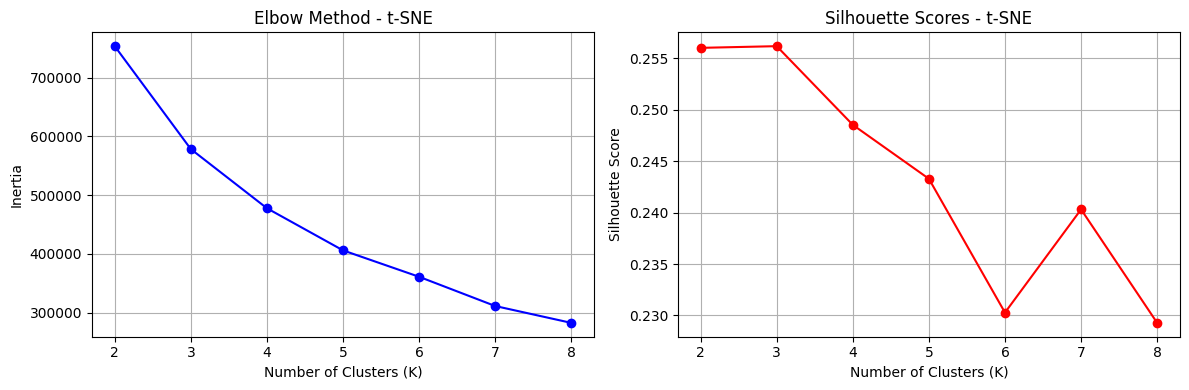

Best K for t-SNE: 3 (Silhouette: 0.256)


In [39]:
def find_optimal_k_means(data, max_k=10, data_name=""):
    """
    Use Elbow Method and Silhouette Score to find optimal K for K-Means
    """
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_k + 1)

    print(f"Finding optimal K for {data_name}...")

    for k in k_range:
        # Fit K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)

        # Calculate metrics
        inertias.append(kmeans.inertia_)
        sil_score = silhouette_score(data, cluster_labels)
        silhouette_scores.append(sil_score)

        print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")

    # Plot the results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Elbow plot
    ax1.plot(k_range, inertias, 'bo-')
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Inertia')
    ax1.set_title(f'Elbow Method - {data_name}')
    ax1.grid(True)

    # Silhouette plot
    ax2.plot(k_range, silhouette_scores, 'ro-')
    ax2.set_xlabel('Number of Clusters (K)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title(f'Silhouette Scores - {data_name}')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Find best K based on silhouette score
    best_k = k_range[np.argmax(silhouette_scores)]
    best_sil = max(silhouette_scores)

    print(f"Best K for {data_name}: {best_k} (Silhouette: {best_sil:.3f})")
    return best_k, silhouette_scores

# Find optimal K for both PCA and t-SNE data
best_k_pca, sil_scores_pca = find_optimal_k_means(features_pca, max_k=8, data_name="PCA")
best_k_tsne, sil_scores_tsne = find_optimal_k_means(features_tsne, max_k=8, data_name="t-SNE")

In [41]:
def compare_clustering_algorithms(data_pca, data_tsne, best_k_pca, best_k_tsne):
    """
    Apply both K-Means and DBSCAN to PCA and t-SNE data
    """
    results = {}

    # K-Means on PCA data
    kmeans_pca = KMeans(n_clusters=best_k_pca, random_state=42)
    kmeans_pca_labels = kmeans_pca.fit_predict(data_pca)

    # K-Means on t-SNE data
    kmeans_tsne = KMeans(n_clusters=best_k_tsne, random_state=42)
    kmeans_tsne_labels = kmeans_tsne.fit_predict(data_tsne)

    # DBSCAN on PCA data (we need to find good eps and min_samples)
    dbscan_pca = DBSCAN(eps=0.8, min_samples=5)
    dbscan_pca_labels = dbscan_pca.fit_predict(data_pca)

    # DBSCAN on t-SNE data
    dbscan_tsne = DBSCAN(eps=1.5, min_samples=5)
    dbscan_tsne_labels = dbscan_tsne.fit_predict(data_tsne)

    # Store results
    results = {
        'kmeans_pca': kmeans_pca_labels,
        'kmeans_tsne': kmeans_tsne_labels,
        'dbscan_pca': dbscan_pca_labels,
        'dbscan_tsne': dbscan_tsne_labels
    }

    # Calculate metrics for each combination
    print("Clustering Results Comparison:")
    print("-" * 50)

    for name, labels in results.items():
        # Skip if all points are noise (DBSCAN can do this)
        if len(np.unique(labels)) <= 1:
            print(f"{name:15}: All points classified as noise!")
            continue

        # Choose the right data
        data = data_pca if 'pca' in name else data_tsne

        # Calculate metrics
        n_clusters = len(np.unique(labels[labels != -1]))  # Exclude noise (-1)
        n_noise = np.sum(labels == -1)

        if n_clusters > 1:
            sil_score = silhouette_score(data, labels)
            db_score = davies_bouldin_score(data, labels)

            print(f"{name:15}: Clusters={n_clusters:2d}, Noise={n_noise:2d}, "
                  f"Silhouette={sil_score:.3f}, Davies-Bouldin={db_score:.3f}")
        else:
            print(f"{name:15}: Only 1 cluster found")

    return results

clustering_results = compare_clustering_algorithms(features_pca, features_tsne, best_k_pca, best_k_tsne)

Clustering Results Comparison:
--------------------------------------------------
kmeans_pca     : Clusters= 6, Noise= 0, Silhouette=0.335, Davies-Bouldin=0.953
kmeans_tsne    : Clusters= 3, Noise= 0, Silhouette=0.253, Davies-Bouldin=1.262
dbscan_pca     : All points classified as noise!
dbscan_tsne    : All points classified as noise!


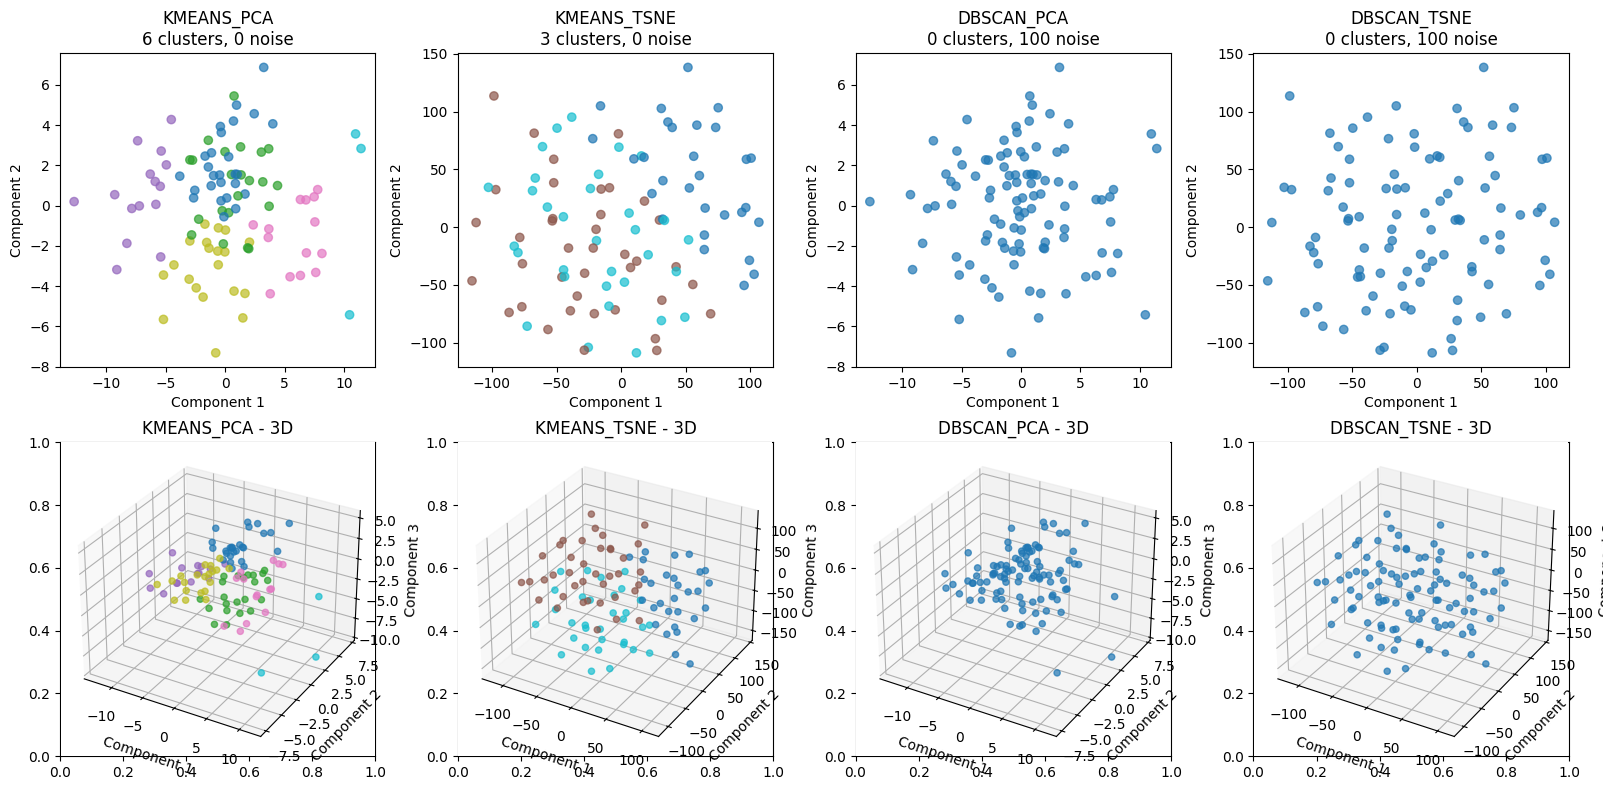

In [42]:
def visualize_clustering_results(data_pca, data_tsne, clustering_results):
    """
    Create a comprehensive visualization of all clustering results
    """
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    methods = ['kmeans_pca', 'kmeans_tsne', 'dbscan_pca', 'dbscan_tsne']
    data_sources = [data_pca, data_tsne, data_pca, data_tsne]

    for i, (method, data) in enumerate(zip(methods, data_sources)):
        labels = clustering_results[method]

        # 2D plot (top row)
        ax_2d = axes[0, i]
        scatter = ax_2d.scatter(data[:, 0], data[:, 1], c=labels,
                               cmap='tab10', alpha=0.7)
        ax_2d.set_title(f'{method.upper()}')
        ax_2d.set_xlabel('Component 1')
        ax_2d.set_ylabel('Component 2')

        # Add cluster count to title
        n_clusters = len(np.unique(labels[labels != -1]))
        n_noise = np.sum(labels == -1)
        ax_2d.set_title(f'{method.upper()}\n{n_clusters} clusters, {n_noise} noise')

        # 3D plot (bottom row)
        ax_3d = fig.add_subplot(2, 4, i+5, projection='3d')
        ax_3d.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels,
                     cmap='tab10', alpha=0.7)
        ax_3d.set_title(f'{method.upper()} - 3D')
        ax_3d.set_xlabel('Component 1')
        ax_3d.set_ylabel('Component 2')
        ax_3d.set_zlabel('Component 3')

    plt.tight_layout()
    plt.show()

visualize_clustering_results(features_pca, features_tsne, clustering_results)

In [44]:
def evaluate_clustering_methods(pca_data, tsne_data, clustering_results):
    from sklearn.metrics import silhouette_score, davies_bouldin_score

    eval_summary = {}
    methods = {
        'KMeans_PCA': (clustering_results['kmeans_pca'], pca_data),
        'KMeans_tSNE': (clustering_results['kmeans_tsne'], tsne_data),
        'DBSCAN_PCA': (clustering_results['dbscan_pca'], pca_data),
        'DBSCAN_tSNE': (clustering_results['dbscan_tsne'], tsne_data)
    }

    for name, (labels, data) in methods.items():
        result = {}
        unique = np.unique(labels)
        n_clusters = len(unique[unique != -1])
        n_noise = np.sum(labels == -1)

        result['n_clusters'] = n_clusters
        result['n_noise'] = n_noise

        if 1 < n_clusters < len(labels):
            try:
                result['silhouette'] = silhouette_score(data, labels)
                result['davies_bouldin'] = davies_bouldin_score(data, labels)
            except:
                result['silhouette'] = None
                result['davies_bouldin'] = None
        else:
            result['silhouette'] = None
            result['davies_bouldin'] = None

        eval_summary[name] = result

    return eval_summary

In [45]:
eval_results = evaluate_clustering_methods(features_pca, features_tsne, clustering_results)
pd.DataFrame(eval_results).T

,n_clusters,n_noise,silhouette,davies_bouldin
KMeans_PCA,6.0,0.0,0.335067,0.952624
KMeans_tSNE,3.0,0.0,0.252623,1.262115
DBSCAN_PCA,0.0,100.0,NaN,NaN
DBSCAN_tSNE,0.0,100.0,NaN,NaN


##Evaluating Clustering Performance: K-Means vs DBSCAN
####Cluster Compactness & Separation:
K-Means performed better than DBSCAN in terms of clustering quality. Using PCA-reduced features, K-Means achieved the highest silhouette score and the lowest Davies-Bouldin index, indicating well-separated and compact clusters. DBSCAN, especially when applied to t-SNE features, detected fewer clusters and more noise points, leading to lower performance on these metrics.

####Visual Interpretability:
Visually, t-SNE plots with DBSCAN showed more natural groupings and handled non-linear shapes better, but these clusters did not always align with strong metric scores. K-Means + PCA, while less visually striking, formed more balanced and well-separated clusters that performed better quantitatively.

Conclusion:
K-Means with PCA offers better metric-based clustering, while DBSCAN with t-SNE provides more visually intuitive but less stable clustering performance.

### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.
- Justify why certain clustering methods worked better.
- Relate findings to real-world clustering challenges.

###Clustering Interpretation & Final Analysis:
I noticed that the K-Means with PCA gave the best clustering performance, producing compact, balanced clusters with strong evaluation metrics. DBSCAN underperformed due to difficulty handling uniformly dense data and high sensitivity to parameter tuning. Dimensionality reduction, especially with PCA, was essential—it reduced noise, preserved global structure, and made the clustering space more meaningful. While t-SNE enhanced visual clarity, it distorted distances, which hurt clustering accuracy. These results reflect real-world challenges where choosing the right dimensionality reduction and clustering method depends heavily on the data’s structure and algorithm assumptions.